In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from scipy.spatial import distance
import time

In [3]:
nlp = spacy.load('en_core_web_lg')

In [3]:
def find_most_similar_word(pos_words, neg_words): 
    vector = nlp.vocab[pos_words[0]].vector
    for _ in range(1, len(pos_words)):
        vector += nlp.vocab[pos_words[_]].vector
    for _ in range(0, len(neg_words)): 
        vector -= nlp.vocab[neg_words[_]].vector
    
    similarities = []
    
    cosine_sim = lambda x, y: 1 - distance.cosine(x, y)
    for word in nlp.vocab: 
        if not word.has_vector: 
            continue
        
        similarities.append((word, cosine_sim(vector, word.vector)))
        
    similarities = sorted(similarities, key=lambda x: -x[1])
    return similarities[:20]

In [4]:
words = find_most_similar_word(['queen', 'man'], ['woman'])
for word in words: 
    print(word[0].text)

queen
Queen
QUEEN
King
KING
king
KIng
Kings
KINGS
kings
queens
QUEENS
Queens
Prince
PRINCE
prince
lord
Lord
LORD
THRONE


In [19]:
target = nlp("request")
 
doc1 = nlp('''What is our next deadline?''')
doc2 = nlp('''The first action item is to do this.''')
doc3 = nlp('''I like swimming.''')
 
print(target.similarity(doc1))  # 0.8901765218466683
print(target.similarity(doc2))  # 0.9115828449161616
print(target.similarity(doc3))  # 0.7822956752876101

0.48412522502224403
0.5001460102882922
0.2963024678059154


In [6]:
train = pd.read_csv('/Users/ash/Downloads/NLP/data/bbc/processed_data/train.csv')
test = pd.read_csv('/Users/ash/Downloads/NLP/data/bbc/processed_data/test.csv')
val = pd.read_csv('/Users/ash/Downloads/NLP/data/bbc/processed_data/val.csv')

In [41]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(max_df=0.95, min_df=2)
# corpus = list(train['text']) + list(test['text']) + list(val['text'])
# vectorizer.fit(corpus)

# vectors = vectorizer.transform(train['text'])

# from sklearn.decomposition import LatentDirichletAllocation
# lda = LatentDirichletAllocation(n_components=5, max_iter=10,
#                                 learning_method='batch',
#                                 random_state=25)
# lda.fit(vectors)

# def print_top_words(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #%d: " % topic_idx
#         message += " ".join([feature_names[i]
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#     print()


# names = vectorizer.get_feature_names()
# print_top_words(lda, names, 20)

In [7]:
def visualize_cluster_results(count):
    print('Clusters:\n', counts['text'])
    plt.figure(figsize = (30,20))
    for cluster in range(6):
        zeros = count.loc[cluster]['text']
        plt.subplot(3,3, cluster+1)
        zeros.plot(kind='bar')
        plt.title('Cluster {}, % Correct: {}'.format(cluster,max(zeros)/sum(zeros)))
        
from sklearn.cluster import KMeans, DBSCAN

Clusters:
 predicted  cat          
0          business          33
           entertainment     18
           politics         247
           sport             14
           tech              16
1          business           7
           entertainment      4
           politics           3
           tech             219
2          business         286
           entertainment      4
           politics          10
           tech               4
3          entertainment      2
           politics           1
           sport             80
4          business           1
           entertainment    218
           politics           1
           tech               3
5          business           2
           entertainment      5
           politics           6
           sport            227
           tech              13
Name: text, dtype: int64


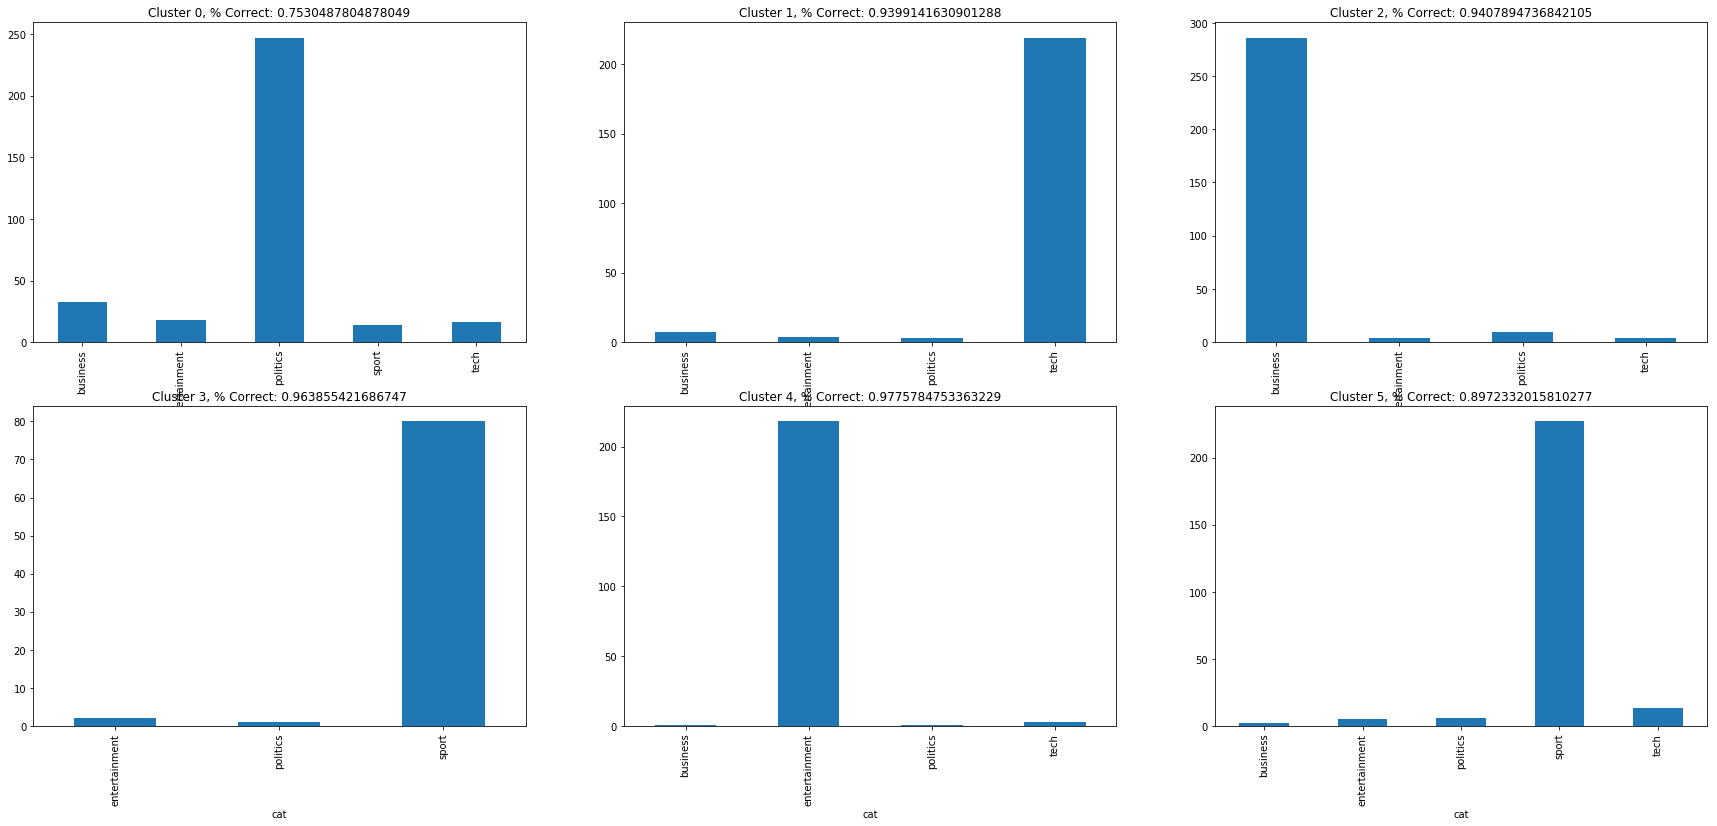

In [8]:
train_nlps = [nlp(text) for text in train['text']]
train_vecs = [text.vector for text in train_nlps]
clusterer = KMeans(6)
clusterer.fit(train_vecs)

train['predicted'] = clusterer.predict(train_vecs)

counts = train.groupby(['predicted', 'cat']).count()
counts['text']  
visualize_cluster_results(counts)    

Clusters:
 predicted  cat          
0          business          1
           entertainment    46
           tech              3
1          entertainment     5
           tech             59
2          business         72
           entertainment     1
           politics          5
3          sport            16
4          business          1
           entertainment     1
           sport            64
           tech              1
5          business         12
           entertainment     1
           politics         60
           sport             6
           tech              2
Name: text, dtype: int64


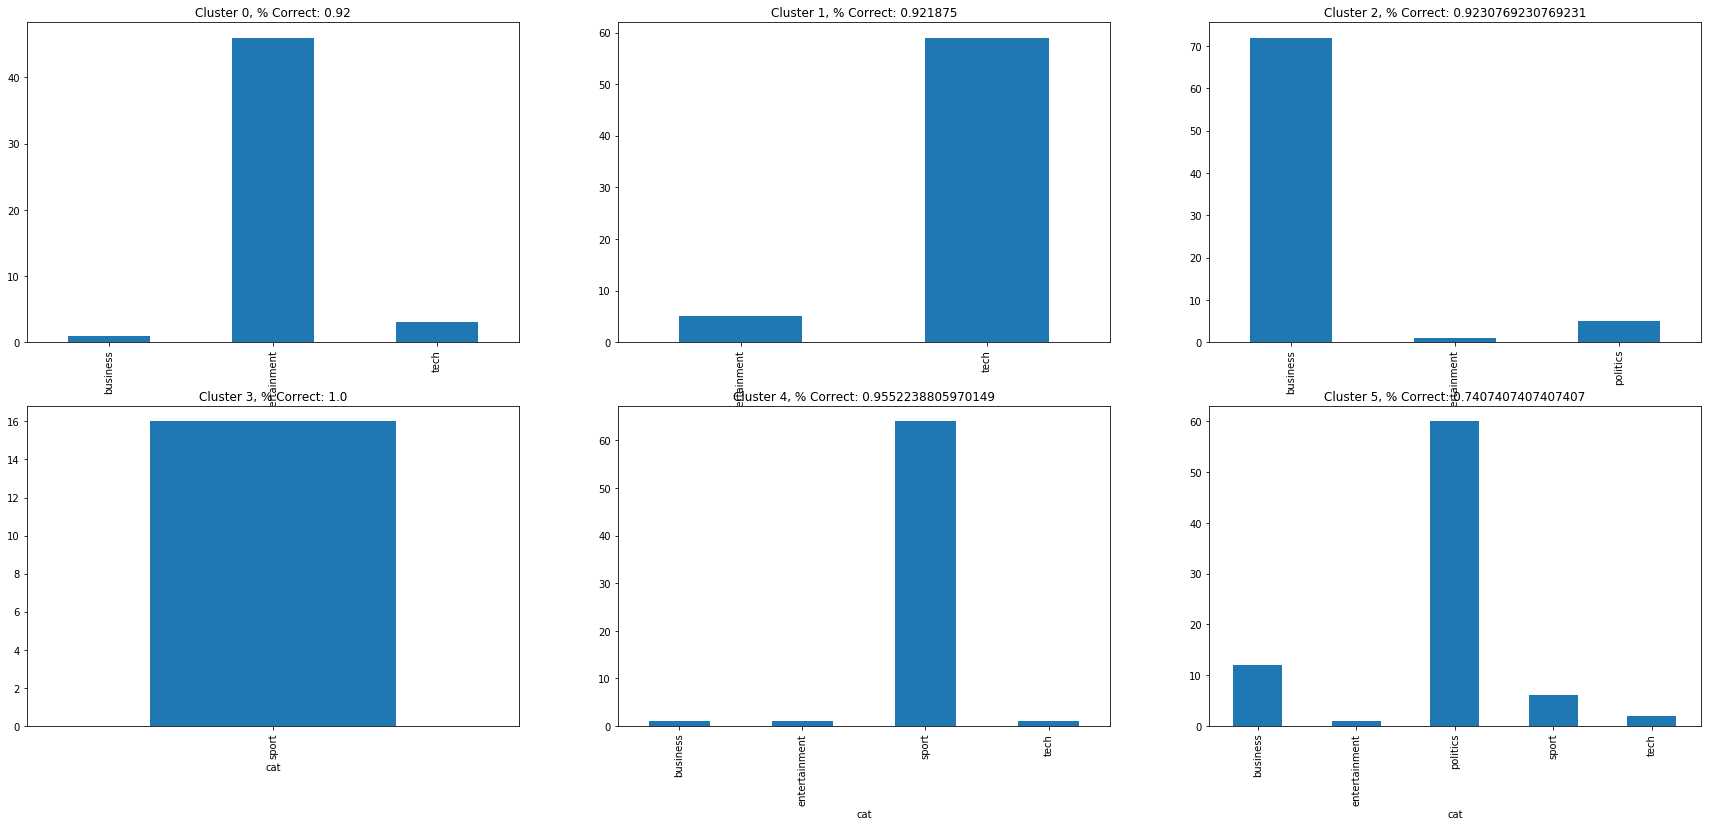

In [6]:
val_nlps = [nlp(text) for text in val['text']]
val_vecs = [text.vector for text in val_nlps]

val['predicted'] = clusterer.predict(val_vecs)

counts = val.groupby(['predicted', 'cat']).count()
counts['text']  
visualize_cluster_results(counts)    

Clusters:
 predicted  cat          
0          entertainment    69
           sport             2
           tech              3
1          business          3
           entertainment     2
           tech             71
2          business         83
           entertainment     2
           politics          7
3          business          1
           politics          1
           sport            24
4          entertainment     3
           sport            72
           tech              3
5          business          8
           entertainment     5
           politics         76
           sport             6
           tech              4
Name: text, dtype: int64


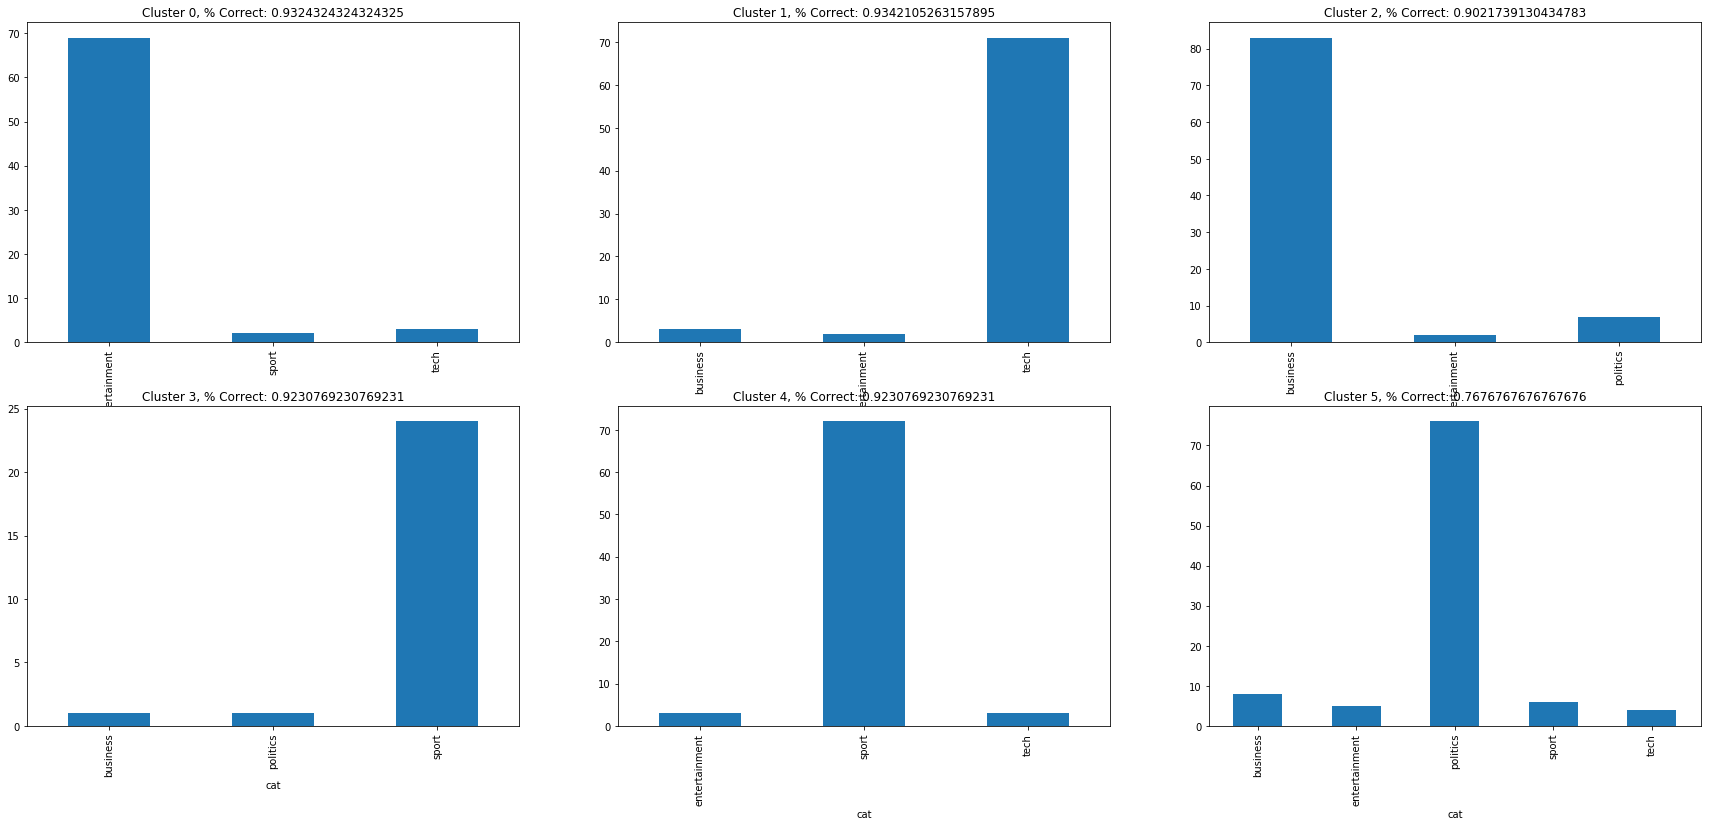

In [7]:
test_nlps = [nlp(text) for text in test['text']]
test_vecs = [text.vector for text in test_nlps]

test['predicted'] = clusterer.predict(test_vecs)

counts = test.groupby(['predicted', 'cat']).count()
counts['text']  
visualize_cluster_results(counts)    

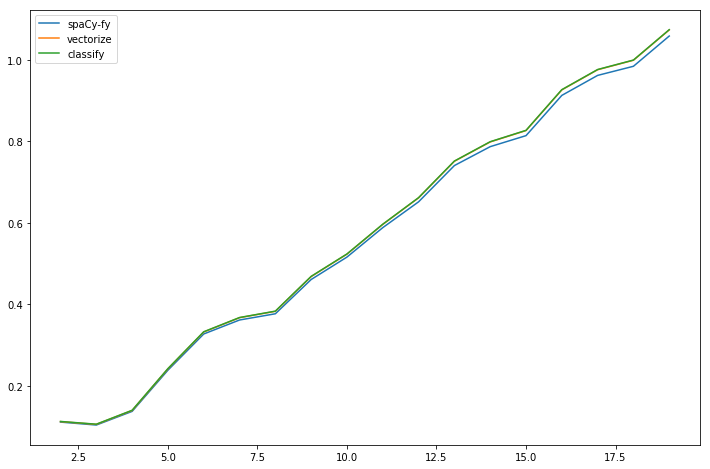

In [140]:
import time

t1, t2, t3 = [], [], []
for _ in range(2, 20):
#     print(_)
    start = time.time()
    test_nlps = [nlp(text) for text in test['text'][:_]]
    t1.append(time.time()-start)
    
    test_vecs = [text.vector for text in test_nlps]
    t2.append(time.time()-start)
    
    clusterer.predict(test_vecs)
    t3.append(time.time()-start)
    

plt.figure(figsize=(12,8))
plt.plot(range(2,20), t1, label='spaCy-fy')
plt.plot(range(2,20), t2, label='vectorize')
plt.plot(range(2,20), t3, label='classify')
plt.legend()
plt.show()

In [141]:
%%timeit

test_nlps = [nlp(text) for text in test['text'][:5]]
test_vecs = [text.vector for text in test_nlps]
clusterer.predict(test_vecs)

281 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()

en.fit(train['cat'])

LabelEncoder()

<IPython.core.display.Javascript object>


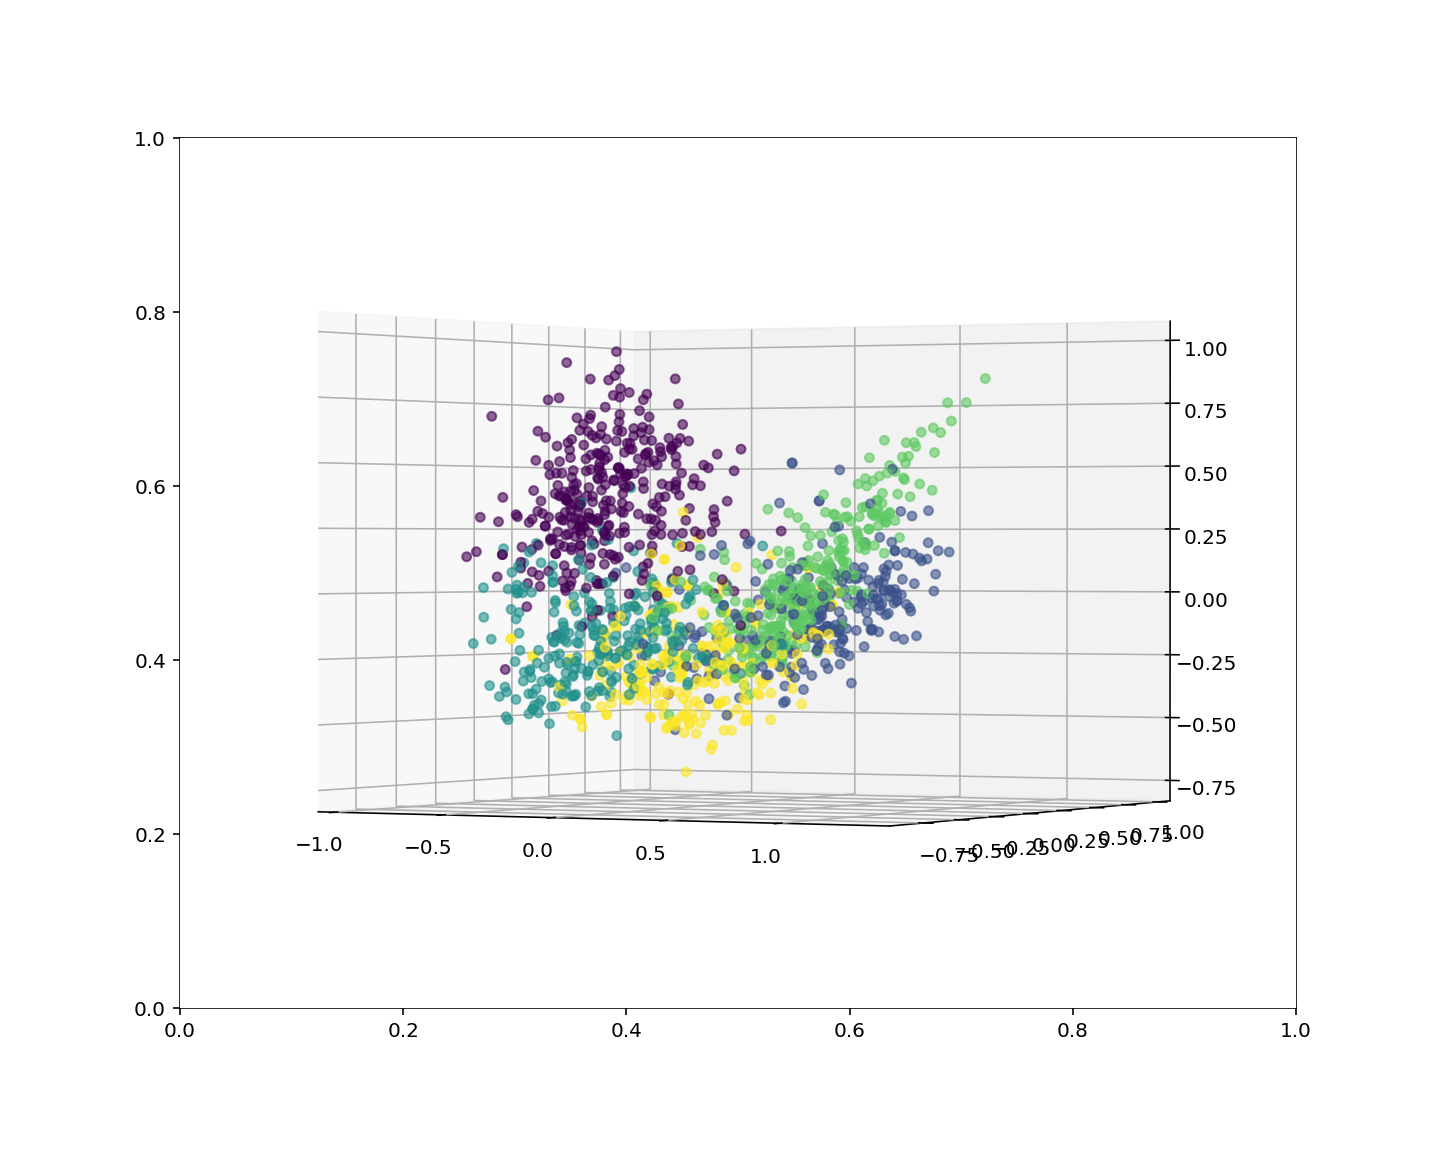

In [52]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D 
mat = np.array(train_vecs)
trans = pca.fit_transform(mat)

labels = en.transform(train['cat'])
fig, ax = plt.subplots(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:, 1], trans[:,2], c=labels, alpha=0.6)

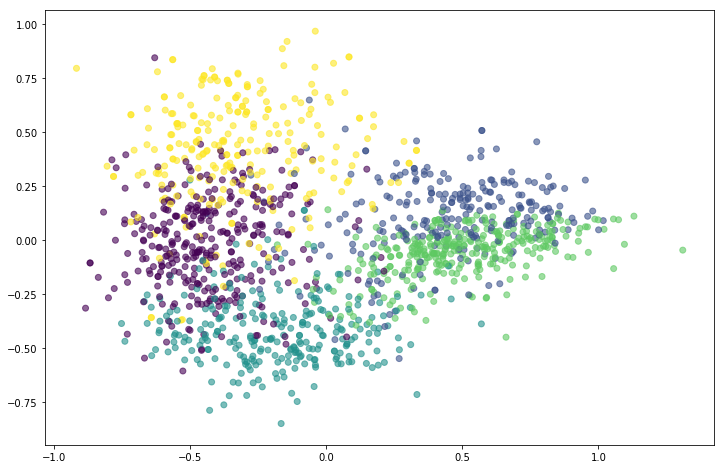

In [41]:
%matplotlib inline
mat = np.array(train_vecs)
# trans = pca.fit_transform(mat)

labels = en.transform(train['cat'])
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(trans[:,0], trans[:, 1], c=labels, alpha=0.6)
plt.show()

<IPython.core.display.Javascript object>


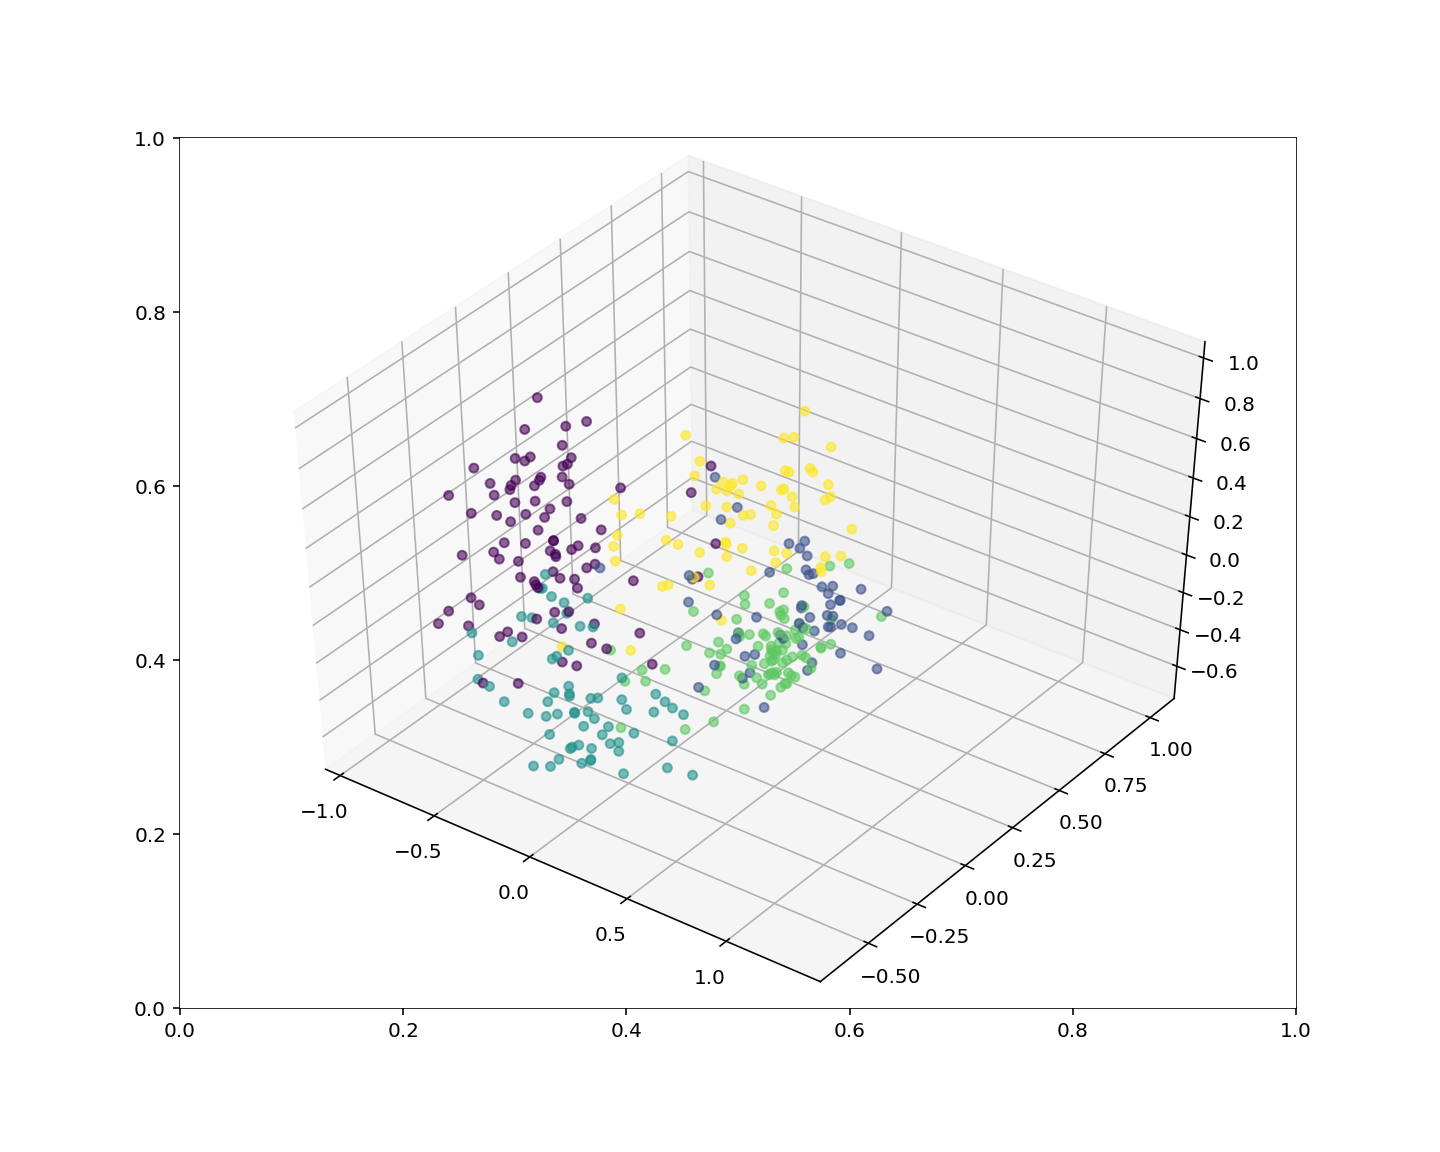

In [43]:
%matplotlib notebook
mat = np.array(val_vecs)
trans = pca.fit_transform(mat)

labels = en.transform(val['cat'])
fig, ax = plt.subplots(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:, 1], trans[:,2], c=labels, alpha=0.6)

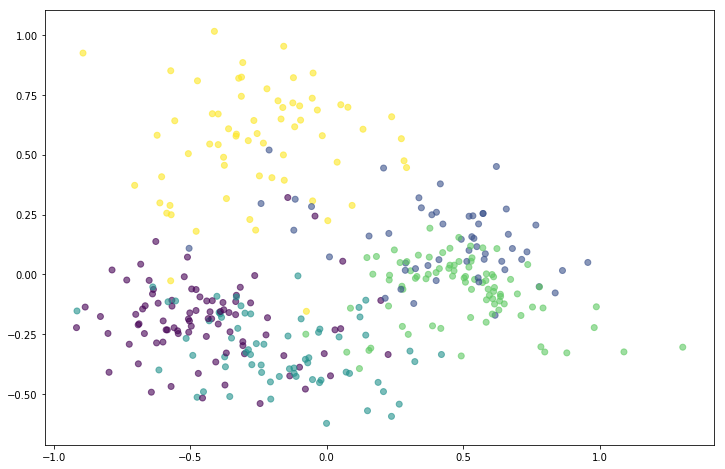

In [45]:
%matplotlib inline
mat = np.array(val_vecs)
# trans = pca.fit_transform(mat)

labels = en.transform(val['cat'])
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(trans[:,0], trans[:, 1], c=labels, alpha=0.6)
plt.show()

<IPython.core.display.Javascript object>


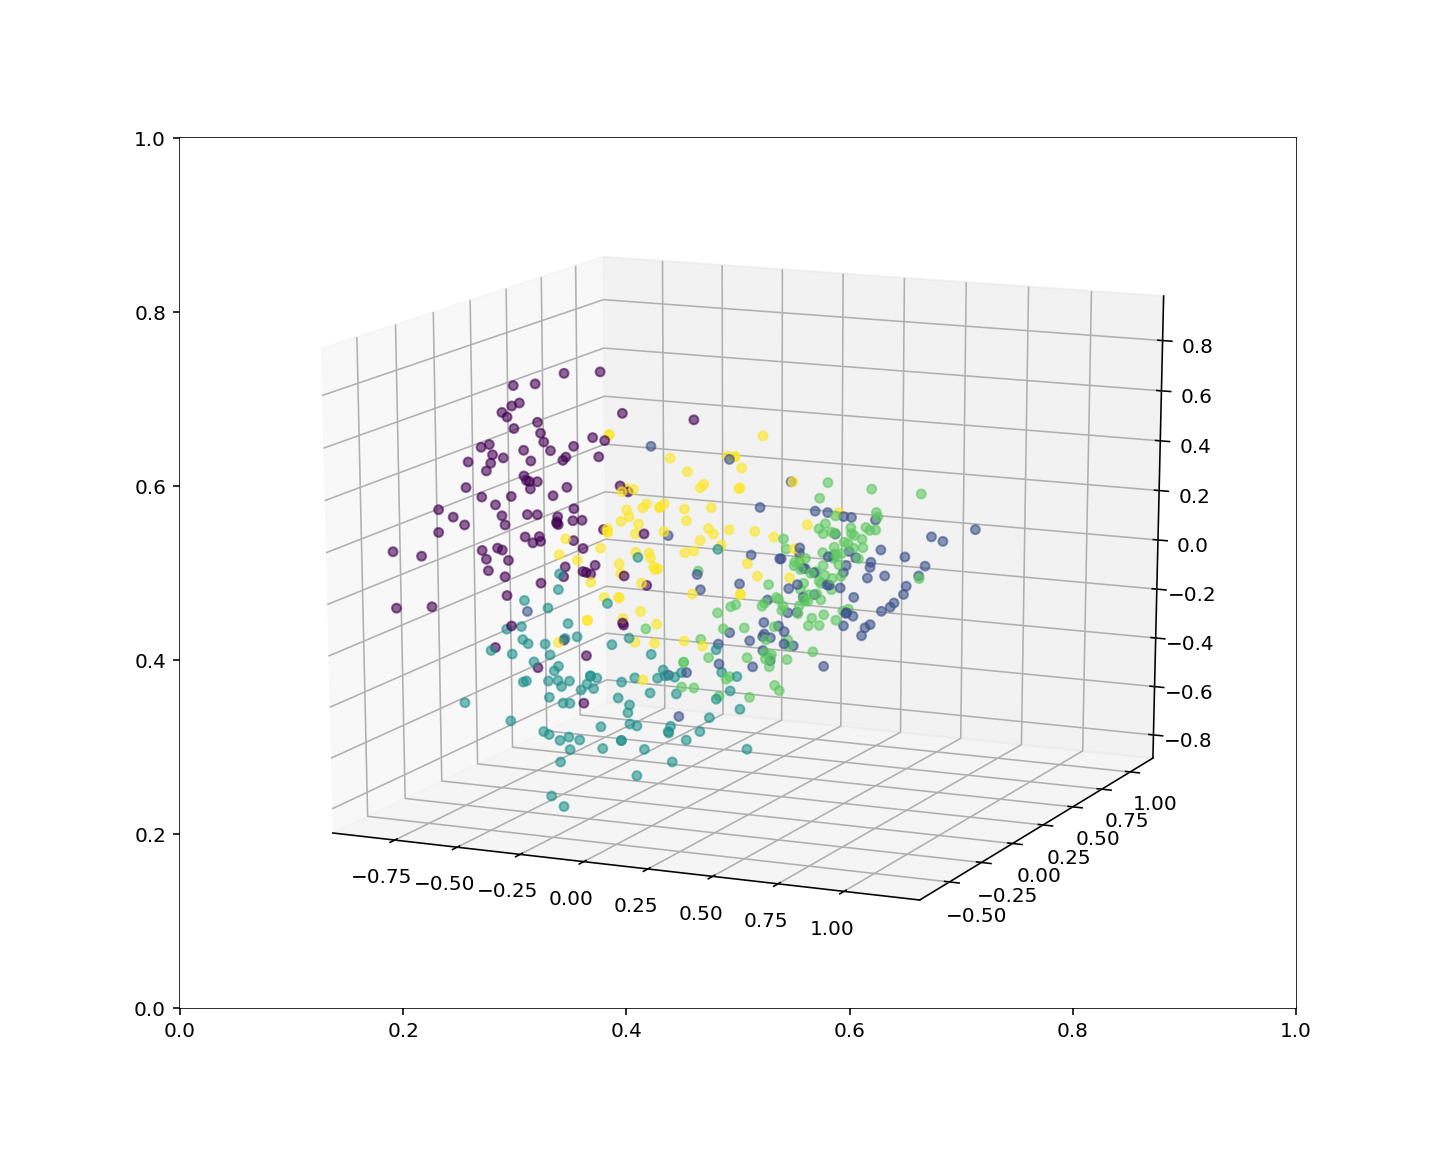

In [47]:
%matplotlib notebook
mat = np.array(test_vecs)
trans = pca.fit_transform(mat)

labels = en.transform(test['cat'])
fig, ax = plt.subplots(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trans[:,0], trans[:, 1], trans[:,2], c=labels, alpha=0.6)

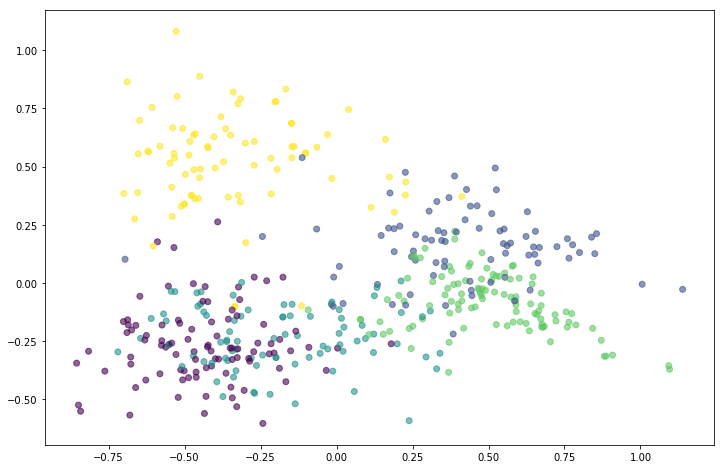

In [50]:
%matplotlib inline
mat = np.array(test_vecs)
# trans = pca.fit_transform(mat)

labels = en.transform(test['cat'])
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(trans[:,0], trans[:, 1], c=labels, alpha=0.6)
plt.show()

In [10]:
from sklearn.manifold import TSNE

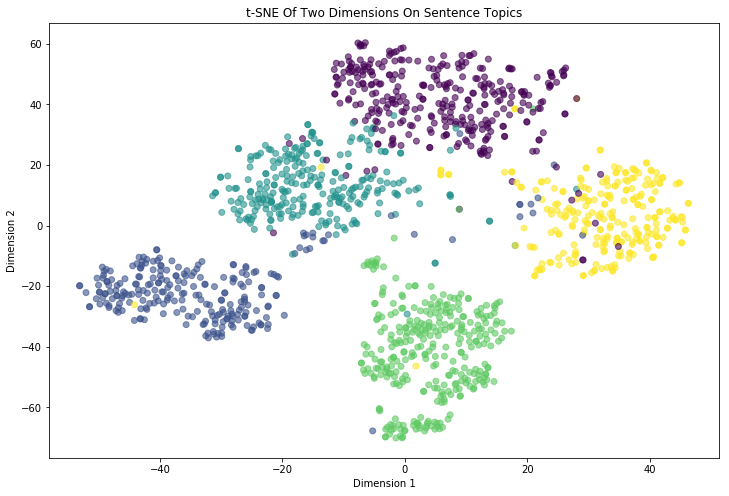

In [13]:
%matplotlib inline
mat = np.array(train_vecs)
sne = TSNE(n_components=2)
trans = sne.fit_transform(mat)

labels = en.transform(train['cat'])
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(trans[:,0], trans[:, 1], c=labels, alpha=0.6)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Of Two Dimensions On Sentence Topics')
plt.show()